# Clustering (KMeans, DBSCAN, OPTICS, Spectral Clustering, Hierarchical Clustering)

**Исполнители (ФИО):** Буканов Иван

---



Здравствуйте, на этом семинаре вы познакомитесь с задачей Кластеризации, методами К-средних, DBSCAN, его модификацией OPTICS, Спектральной кластеризацией, Иерархической кластеризацией, а так же с различными метриками качества кластеризации

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import warnings
warnings.filterwarnings("ignore", message="The number of unique classes.*") 
warnings.filterwarnings("ignore", message="Graph is not fully connected.*") 



[Метрики качества кластеризации](https://www.geeksforgeeks.org/machine-learning/clustering-metrics/)

[Сравнение методов кластеризаций](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)

[Иерархическая кластеризация](https://www.geeksforgeeks.org/machine-learning/hierarchical-clustering-with-scikit-learn/)

## Задача 1


### Введение в Кластеризацию

Для начала познакомимся с методом К-средних. Этот метод основан на предположении, что кластеры имеют сферическую структуру (куча). Создайте две непересекающиеся кучи и примените к ним метод [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), визуализируйте результаты


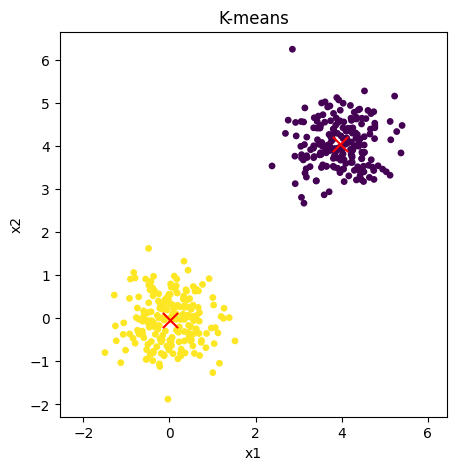

In [118]:
# Две непересекающиеся кучи
n = 200
blob1 = np.array([0.0, 0.0]) + 0.55 * np.random.randn(n, 2)
blob2 = np.array([4.0, 4.0]) + 0.55 * np.random.randn(n, 2)
X = np.vstack([blob1, blob2])

# K-means
kmeans = KMeans(n_clusters=2, n_init=10)
labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], s=15, c=labels)
plt.scatter(centers[:, 0], centers[:, 1], s=120, marker="x", color="red")
plt.title("K-means")
plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal")
plt.show()

Однако, с данными, которые устроены более сложным образом, например, ленточные кластеры, KMeans работает хуже.

Создайте две смещенные параболы вида $X_{1}\sim R[-1.4, 0.6], X_{2}\sim R[-0.6, 1.4], Y_{1}\sim X_{1}^{2} - 0.6 + Z_{1}, Y_{1}\sim X_{2}^{2} + 0.6 + Z_{2}$, где $Z_{i}\sim \mathcal{N}(0, 0.4)$ и примените этот метод к ним, визуализируйте результат

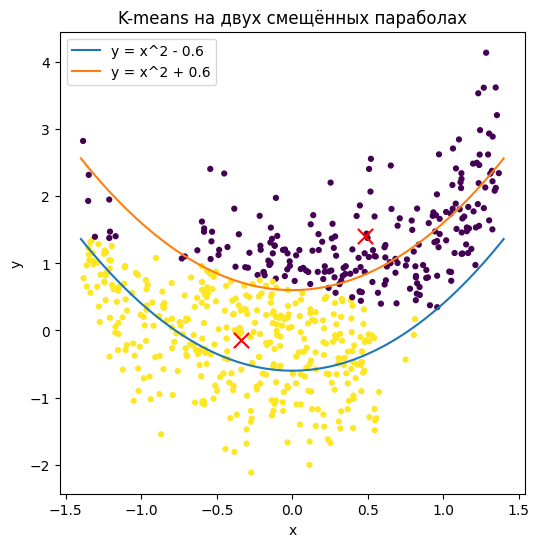

In [119]:
# Параметры и данные
n = 300
x1 = np.random.uniform(-1.4, 0.6, n)
x2 = np.random.uniform(-0.6, 1.4, n)
z1 = np.random.normal(0.0, np.sqrt(0.4), n)
z2 = np.random.normal(0.0, np.sqrt(0.4), n)

y1 = x1**2 - 0.6 + z1
y2 = x2**2 + 0.6 + z2

X = np.column_stack([np.r_[x1, x2], np.r_[y1, y2]])

# K-means
kmeans = KMeans(n_clusters=2, n_init=20)
labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

# Визуализация
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=12, c=labels)
plt.scatter(centers[:, 0], centers[:, 1], s=120, marker="x", color="red")
t = np.linspace(-1.4, 1.4, 400)
plt.plot(t, t**2 - 0.6, label="y = x^2 - 0.6")
plt.plot(t, t**2 + 0.6, label="y = x^2 + 0.6")
plt.title("K-means на двух смещённых параболах")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

Метод [Spectral Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) позволяет работать со сложными структурами за счёт преобразования данным с помощью нелинейного ядра. Теперь примените этот метод к параболам, визуализируйте результаты

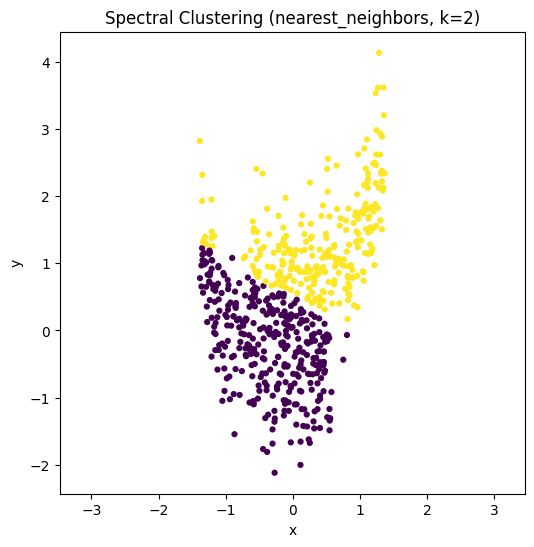

In [120]:
spec = SpectralClustering(
    n_clusters=2,
    affinity="nearest_neighbors",
    n_neighbors=15,
    assign_labels="kmeans"  # разбиение в спектральном пространстве
)
labels_sc = spec.fit_predict(X)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=12, c=labels_sc)
plt.title("Spectral Clustering (nearest_neighbors, k=2)")
plt.xlabel("x"); plt.ylabel("y"); plt.axis("equal")
plt.show()

**Вопрос:** Почему данные кластеризовались именно так в этих методах? Обоснуйте свой ответ

Кластеризация получилась практически одинаковой, небольшие отличия есть лишь на левой границе разделений, где Spectral Clustering "поймало" ветвь нижней параболы.
Геометрия данных: для одного и того же x средние отличаются на 1.2 => $Y_2-Y_1=1.2+(Z_2-Z_1)\sim \mathcal N(1.2,\,0.8)$.
Вероятность перепутать ветви: $P(Y_2<Y_1)\approx \Phi(-1.2/\sqrt{0.8})\approx 0.089$ => перекрытие около 9%, компоненты уже неплохо разделены по построению.

Теперь возьмите данные из файла Aggregation.txt. Используя в качестве фичей первые два столбца, визуализируйте данные и сделайте предположение об оптимальном количестве кластеров

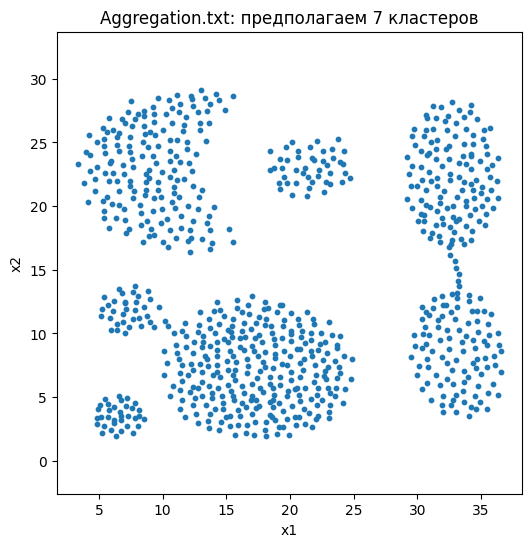

In [121]:
path = "data/Aggregation.txt"
df = pd.read_csv(path, sep=r"\s+", header=None)
X = df.iloc[:, :2].to_numpy()

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Aggregation.txt: предполагаем 7 кластеров")
plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal")
plt.show()

Раскрасьте данные, используя третий столбец

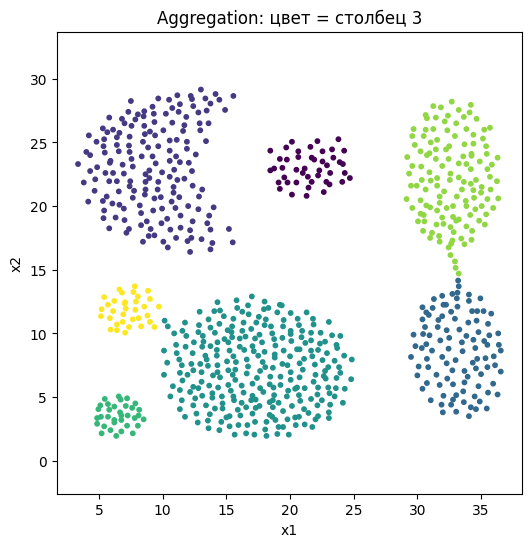

In [122]:
labels = df.iloc[:, 2].to_numpy()

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=10, c=labels)
plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal"); plt.title("Aggregation: цвет = столбец 3")
plt.show()

**Вопрос:** совпадает ли это с вашей гипотезой?

Да, но разбиение было очевидным

Примените к этим данным алгоритмы Kmeans и Spectral Clustering. Попробуйте разное количество кластеров $k=3,5,7,10$ Визуализируйте результат работы алгоритмов

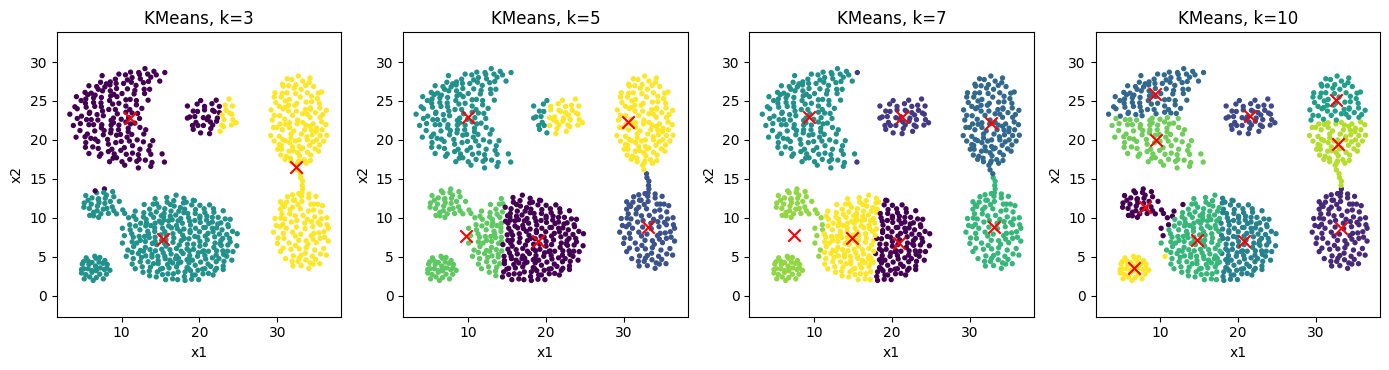

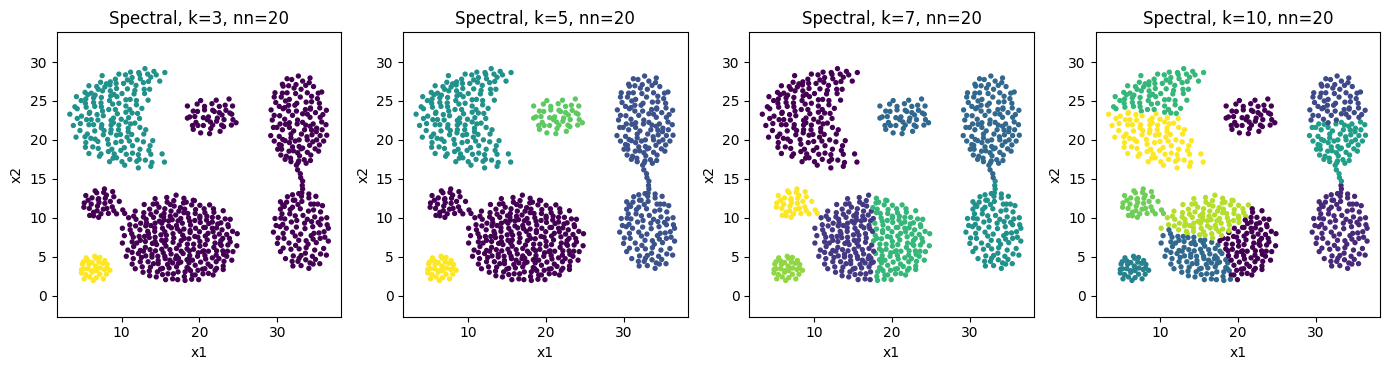

In [123]:
ks = [3, 5, 7, 10]
y_kmeans = {}
y_spec   = {}

# K-means
fig, axes = plt.subplots(1, len(ks), figsize=(14, 3.8))
for ax, k in zip(axes, ks):
    km = KMeans(n_clusters=k, n_init=10)
    y_kmeans[k] = km.fit_predict(X)
    ax.scatter(X[:, 0], X[:, 1], s=8, c=y_kmeans[k])
    ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], marker="x", s=80, color="red")
    ax.set_title(f"KMeans, k={k}")
    ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.axis("equal")
plt.tight_layout(); plt.show()

# Spectral Clustering 
# heuristic для числа соседей в графе
n_neighbors = max(8, min(20, int(np.sqrt(len(X)))))
fig, axes = plt.subplots(1, len(ks), figsize=(14, 3.8))
for ax, k in zip(axes, ks):
    sc = SpectralClustering(
        n_clusters=k,
        affinity="nearest_neighbors",
        n_neighbors=n_neighbors,
        assign_labels="kmeans"
    )
    y_spec[k] = sc.fit_predict(X)
    ax.scatter(X[:, 0], X[:, 1], s=8, c=y_spec[k])
    ax.set_title(f"Spectral, k={k}, nn={n_neighbors}")
    ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.axis("equal")
plt.tight_layout(); plt.show()

Проверьте результат кластеризации с помощью метрики [NMI](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html)

In [4]:
from sklearn.metrics import normalized_mutual_info_score as NMI

In [124]:

y_true = df.iloc[:, 2].to_numpy()

rows = []
for k in ks:
    rows.append({
        "k": k,
        "NMI_KMeans": NMI(y_true, y_kmeans[k]),
        "NMI_Spectral": NMI(y_true, y_spec[k]),
    })

res = pd.DataFrame(rows).sort_values("k")
res[["NMI_KMeans", "NMI_Spectral"]] = res[["NMI_KMeans", "NMI_Spectral"]].round(4)
print(res.to_string(index=False))

 k  NMI_KMeans  NMI_Spectral
 3      0.7440        0.5778
 5      0.8143        0.8894
 7      0.8792        0.8849
10      0.8464        0.8025


**Вопрос:** Предположите, почему данные кластеризовались таким образом? Какой из алгоритмов дал лучший результат?

Лучший результат ожидаемо получился у Spectral Clustering. K-means минимизирует $\sum\limits_{i}\|x_i-\mu_{c(i)}\|^2$ и даёт выпуклые области Вороного с линейными границами. Это сливает близкие компоненты, если центры оказываются по одну сторону узкого “моста”, а также режет изогнутые/длинные кластеры на несколько частей при неподходящем k.
Spectral Clustering строит kNN-граф, считает собственные векторы нормализованного лапласиана L и фактически оптимизирует normalized cut. Межкластерных рёбер мало, внутри много, разрез проходит по “тонким” местам. Поэтому при k=7 почти идеальное соответствие меткам; при k=5 недосегментация, при k=10 лишние разрезы кластеров.

## Задача 2

### DBSCAN, OPTICS

Теперь познакомимся c другим метрическим алгоритмом DBSCAN и его улучшением OPTICS. Эти методы основаны на предположении, что плотность данных внутри кластера больше, чем плотность данных между кластерами. Такое предположение используется алгоритмом для определения оптимального числа кластеров

Создайте три нормальные кучи разной степени разреженности и примените к ним метод [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

In [5]:
from sklearn.cluster import DBSCAN, OPTICS

Кластеров: 3 | Шумовых точек: 71
 label  count
    -1     71
     0    439
     1    240
     2    125


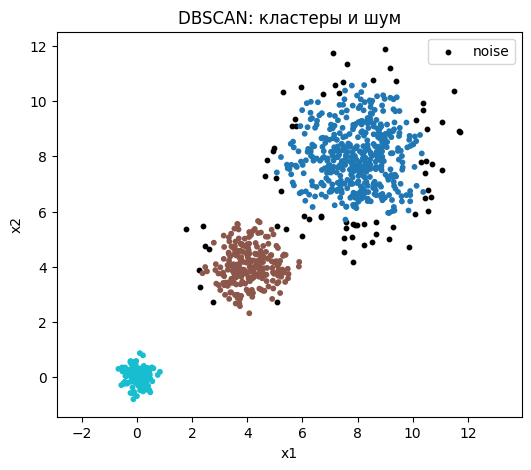

In [126]:

# Данные: 3 кучи с разной разряжённостью
X, _ = make_blobs(
    n_samples=[125, 250, 500],                # разные мощности
    centers=[(0, 0), (4, 4), (8, 8)],        # разнесены в пространстве
    cluster_std=[0.30, 0.70, 1.20],           # разная плотность (чем больше std, тем "реже")
    random_state=None
)

# DBSCAN
db = DBSCAN(eps=0.5, min_samples=10).fit(X)
labels = db.labels_

# Сводка: число кластеров и шум (label = -1)
n_noise = int(np.sum(labels == -1))
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Кластеров: {n_clusters} | Шумовых точек: {n_noise}")

# Таблица размеров кластеров (шум -1)
uniq, cnt = np.unique(labels, return_counts=True)
summary = pd.DataFrame({"label": uniq, "count": cnt}).sort_values("label").reset_index(drop=True)
print(summary.to_string(index=False))

# Визуализация
plt.figure(figsize=(6, 5))
# шум — белым, кластеры — цветами
is_noise = labels == -1
plt.scatter(X[is_noise, 0], X[is_noise, 1], s=10, c="k", label="noise")
plt.scatter(X[~is_noise, 0], X[~is_noise, 1], s=10, c=labels[~is_noise], cmap="tab10")
plt.title("DBSCAN: кластеры и шум")
plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal"); plt.legend()
plt.show()



**Вопрос**: Много ли получилось некластеризованных точек (outliers)?

69

Алгоритм DBSCAN имеет два параметра *eps* - радиус поиска, и *min_samples* - необходимое количество точек внутри радиуса поиска. Изменяя эти параметры, попробуйте искать кластеры разной плотности

In [127]:
eps_grid = np.round(np.linspace(0.2, 1.6, 8), 2) 
min_samples_grid = [3, 5, 8, 12, 16, 24]

rows = []
n_total = len(X)
for eps in eps_grid:
    for ms in min_samples_grid:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X)
        labels = db.labels_
        n_noise = int(np.sum(labels == -1))
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        # порог "плотности" для 2D (эвристика)
        rho_star = ms / (np.pi * eps**2)
        # доля core-точек (ядра), чтобы видеть, что именно проходит порог
        core_ratio = len(getattr(db, "core_sample_indices_", [])) / n_total

        rows.append({
            "eps": float(eps),
            "min_samples": int(ms),
            "rho_star": rho_star,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "noise_share": n_noise / n_total,
            "core_share": core_ratio
        })

res = pd.DataFrame(rows).sort_values(["rho_star", "eps", "min_samples"]).reset_index(drop=True)
# компактный вывод
cols = ["eps","min_samples","rho_star","n_clusters","n_noise","noise_share","core_share"]
res[["rho_star","noise_share","core_share"]] = res[["rho_star","noise_share","core_share"]].round(4)
print(res.to_string(index=False))

 eps  min_samples  rho_star  n_clusters  n_noise  noise_share  core_share
 1.6            3    0.3730           2        0       0.0000      1.0000
 1.4            3    0.4872           2        0       0.0000      1.0000
 1.6            5    0.6217           2        0       0.0000      1.0000
 1.2            3    0.6631           2        0       0.0000      0.9989
 1.4            5    0.8120           2        0       0.0000      0.9954
 1.0            3    0.9549           2        1       0.0011      0.9966
 1.6            8    0.9947           2        0       0.0000      0.9977
 1.2            5    1.1052           2        0       0.0000      0.9931
 1.4            8    1.2992           2        0       0.0000      0.9920
 0.8            3    1.4921           2        1       0.0011      0.9931
 1.6           12    1.4921           2        0       0.0000      0.9943
 1.0            5    1.5915           2        2       0.0023      0.9897
 1.2            8    1.7684           

**Вопрос**: Как меняется количество outliers в зависимости от этих параметров?

Сильнее всего влияет eps, меньше eps -> больше потерянных точек, обратное с минимальным количеством соседей, чем больше надо соседей, тем больше точек теряем при eps=0.2, samples = 24, теряем вообще все точки

Метод OPTICS это модификация DBSCAN, которая предполагает, что кластеры могут иметь разную плотность, а значит и разные радиусы поиска, и пересчитывает их для кластеров

Примените [OPTICS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html), визуализируйте результаты и сравните с DBSCAN

OPTICS: clusters=2, noise=501
DBSCAN: clusters=3, noise=25


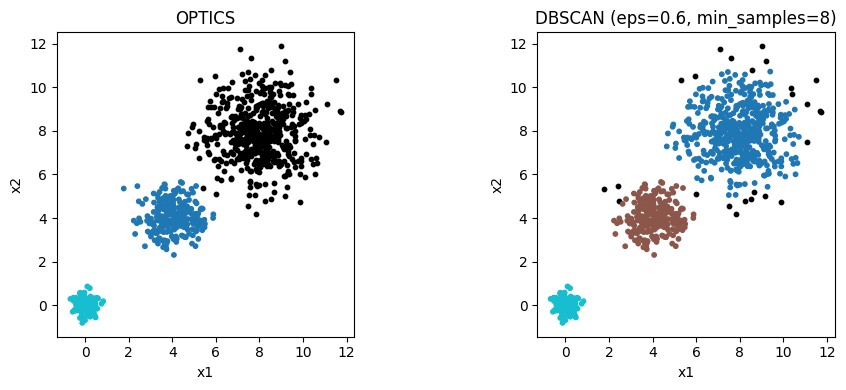

In [128]:


# OPTICS
optics = OPTICS(min_samples=10, xi=0.08, min_cluster_size=max(10, int(0.03 * len(X))))
labels_opt = optics.fit_predict(X)

# DBSCAN
db = DBSCAN(eps=0.6, min_samples=8).fit(X)
labels_db = db.labels_

def summarize(labels, name):
    n_noise = int((labels == -1).sum())
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"{name}: clusters={n_clusters}, noise={n_noise}")

summarize(labels_opt, "OPTICS")
summarize(labels_db,  "DBSCAN")

# Визуализация без sharex/sharey + правильный аспект
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, labels, title in [
    (axes[0], labels_opt, "OPTICS"),
    (axes[1], labels_db,  "DBSCAN (eps=0.6, min_samples=8)"),
]:
    noise = labels == -1
    ax.scatter(X[noise, 0],  X[noise, 1],  s=10, c="k", label="noise")
    ax.scatter(X[~noise, 0], X[~noise, 1], s=10, c=labels[~noise], cmap="tab10")
    ax.set_title(title); ax.set_xlabel("x1"); ax.set_ylabel("x2")
    ax.set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()

**Вопрос:** Сделайте предположение, почему результаты DBSCAN и OPTICS отличаются именно так. Обоснуйте свой ответ

При правильно подобранных параметрах OPTICS, отличий от DBSCAN не наблюдается вообще, он даже несколько хуже делает кластеризацию

Теперь возьмите данные из файла Unbalance.txt. Используя в качестве фичей первые два столбца, визуализируйте данные и сделайте предположение об оптимальном количестве кластеров

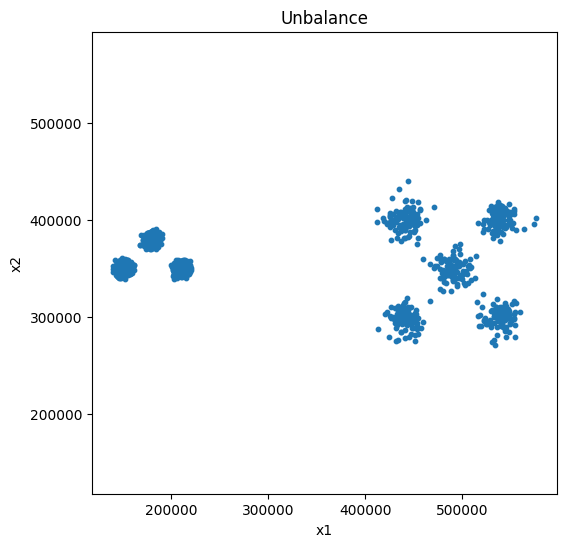

In [129]:

path = "data/Unbalance.txt"
df = pd.read_csv(path, sep=r"\s+", header=None)
X = df.iloc[:, :2].to_numpy()


plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Unbalance")
plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal")
plt.show()

Раскрасьте данные, используя третий столбец(Файл unbalance-labels.txt)

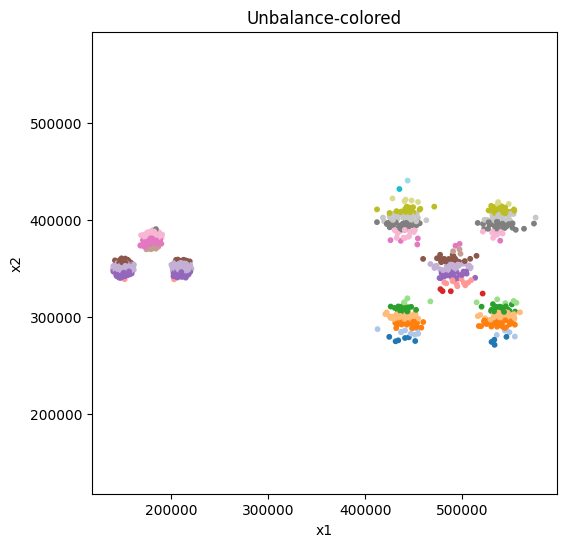

In [130]:
path_lab = "data/unbalance-labels.txt"
df_lab = pd.read_csv(path, sep=r"\s+", header=None)
y = df_lab.iloc[:, 1].to_numpy()

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=10, c=y, cmap="tab20")
plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal"); plt.title("Unbalance-colored")
plt.show()

**Вопрос:** совпадает ли это с вашей гипотезой?

Ну, теперь не совпадает)

Примените к этим данным алгоритмы DBSCAN и OPTICS. Визуализируйте результат работы алгоритма. Поcчитайте метрику NMI

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import normalized_mutual_info_score
from sklearn.neighbors import NearestNeighbors


DBSCAN:    clusters=13, noise=208, eps=0.113, min_samples=8, NMI=0.2718
OPTICS:    clusters=4, noise=19, xi=0.10, min_samples=10, mcs=325, NMI=0.2490


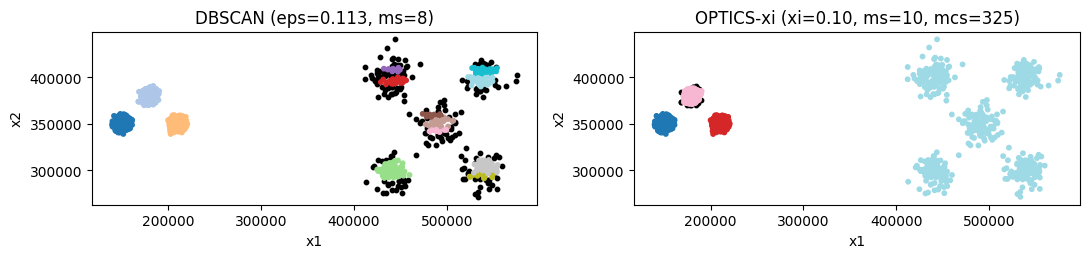

In [132]:

Xs = StandardScaler().fit_transform(X) # Нормировка

# DBSCAN: подберём eps по k-distance (k = min_samples)
min_samples_db = 8
dists, _ = NearestNeighbors(n_neighbors=min_samples_db).fit(Xs).kneighbors(Xs)
kdist = np.sort(dists[:, -1])
eps = float(np.percentile(kdist, 95)) 

db = DBSCAN(eps=eps, min_samples=min_samples_db).fit(Xs)
labels_db = db.labels_
n_noise_db = int(np.sum(labels_db == -1))
n_cl_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)

# OPTICS
min_samples_opt = 10
min_cluster_size = max(10, int(0.05 * len(X)))  # ~5% от выборки
xi = 0.10

opt = OPTICS(min_samples=min_samples_opt, xi=xi, min_cluster_size=min_cluster_size,
             max_eps=np.inf, cluster_method="xi").fit(Xs)
labels_opt = opt.labels_
n_noise_opt = int(np.sum(labels_opt == -1))
n_cl_opt = len(set(labels_opt)) - (1 if -1 in labels_opt else 0)

# NMI
nmi_db  = normalized_mutual_info_score(y, labels_db)
nmi_opt = normalized_mutual_info_score(y, labels_opt)

print(f"DBSCAN:    clusters={n_cl_db}, noise={n_noise_db}, eps={eps:.3f}, min_samples={min_samples_db}, NMI={nmi_db:.4f}")
print(f"OPTICS:    clusters={n_cl_opt}, noise={n_noise_opt}, xi={xi:.2f}, min_samples={min_samples_opt}, mcs={min_cluster_size}, NMI={nmi_opt:.4f}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
for ax, labels, title in [
    (axes[0], labels_db,  f"DBSCAN (eps={eps:.3f}, ms={min_samples_db})"),
    (axes[1], labels_opt, f"OPTICS-xi (xi={xi:.2f}, ms={min_samples_opt}, mcs={min_cluster_size})"),
]:
    noise = labels == -1
    ax.scatter(X[noise, 0],  X[noise, 1],  s=10, c="k", label="noise")
    ax.scatter(X[~noise, 0], X[~noise, 1], s=10, c=labels[~noise], cmap="tab20")
    ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_title(title)
    ax.set_aspect("equal", adjustable="box")
plt.tight_layout(); plt.show()







**Вопрос:** Получилось ли улучшить результаты с помощью метода OPTICS?

Не особо, DBSCAN оказался чуствительнее к мелким склеенным группам из-за маленького eps

## Задача 3

В этой задаче вы познакомитесь с иерархической кластеризацией. До этого вы работали с готовыми методами, которые опираются на предположение о возможной структуре данных. Иерархический подход напротив, позволяет в некотором смысле посмотреть на структуру данных и сделать предположение о числе кластеров

### Знакомство с дендрограммой

Иерархический подход заключается в построении дендрограммы на основе матрицы расстояний (linkage): дерево, визуализирующее расстояния между точками и возможными кластерами. Подробнее [здесь](https://www.geeksforgeeks.org/python/scipy-cluster-hierarchy-dendrogram/)

Подключите необходимые методы

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_rand_score as ARI



Считайте данные из файла dim032

In [138]:
X = pd.read_csv("data/dim032.txt", sep=r"\s+", header=None).to_numpy()
y = pd.read_csv("data/dim032-l.txt", sep=r"\s+", header=None).iloc[:, 0].to_numpy()
y = y[:len(X)]  # гарантируем соответствие длины, чтобы не ловить IndexError



Посчитайте матрицу расстояний linkage и постройте дендрограмму

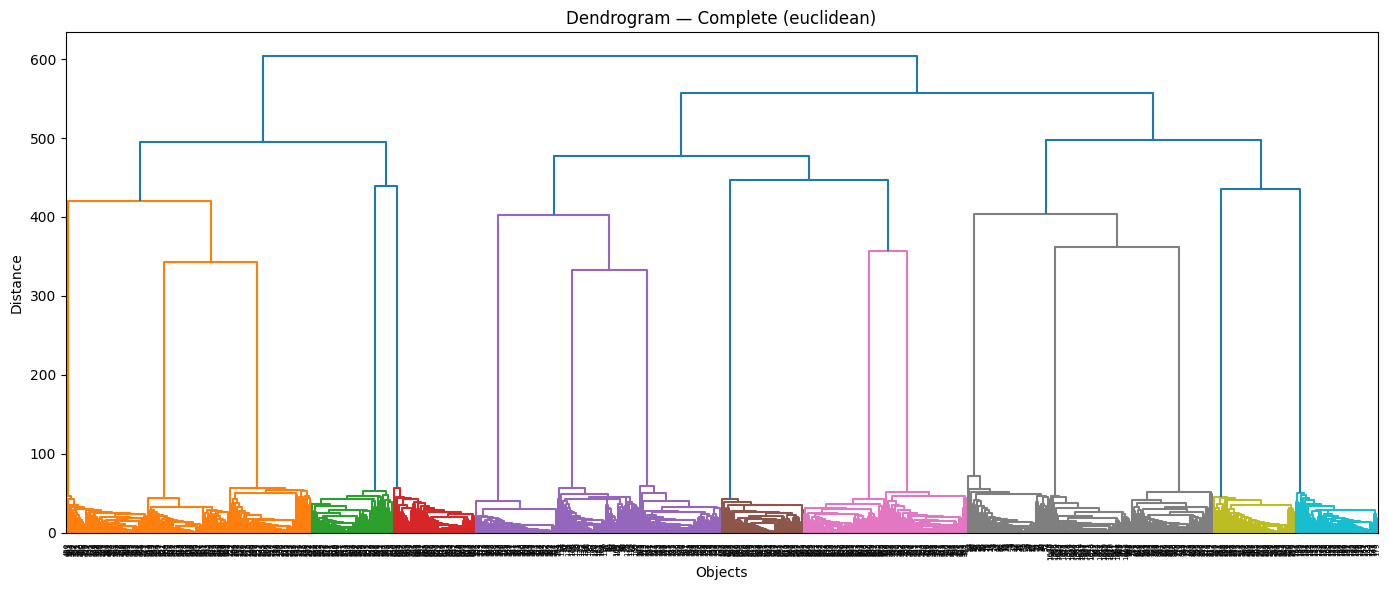

Классов по файлу dim032-l: 21
Кластеров по дендрограмме (по крупнейшему разрыву): 16
Совпадает ли: False


In [144]:
k_true = len(np.unique(y))

# linkage: complete по попарным расстояниям 
Z = linkage(pdist(X, metric="euclidean"), method="complete")

# дендрограмма 
plt.figure(figsize=(14, 6))
dn = dendrogram(Z, labels=[str(i) for i in range(len(X))], leaf_font_size=5)
plt.title("Dendrogram — Complete (euclidean)")
plt.ylabel("Distance")
plt.xlabel("Objects")
plt.tight_layout()
plt.show()

# срез перед крупнейшим скачком по высоте
h = Z[:, 2]                      # высоты слияний
j = int(np.argmax(np.diff(h)))   # индекс самого большого скачка
k_from_jump = len(X) - (j + 1)   # число кластеров до этого слияния

# сравнение с файлом меток
print(f"Классов по файлу dim032-l: {k_true}")
print(f"Кластеров по дендрограмме: {k_from_jump}")
print(f"Совпадает ли: {k_from_jump == k_true}")

# при желании можно получить метки при k_from_jump и при k_true
labels_jump = fcluster(Z, t=k_from_jump, criterion="maxclust")
labels_truek = fcluster(Z, t=k_true,      criterion="maxclust")

**Вопрос:** Сколько кластеров вы можете выделить на дендрограмме? Совпадает ли это с количеством классов в файле dim032-l?


16, нет

Способ подсчёта расстояния в функции linkage можно изменить с помощью параметра *metric*, а за условие объединения кластеров отвечает параметр *method*.

Ознакомьтесь в [документации](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) с возможными значениями параметров *metric* и *method*, постройте несколько дендрограмм с понравившимися вам вариантами

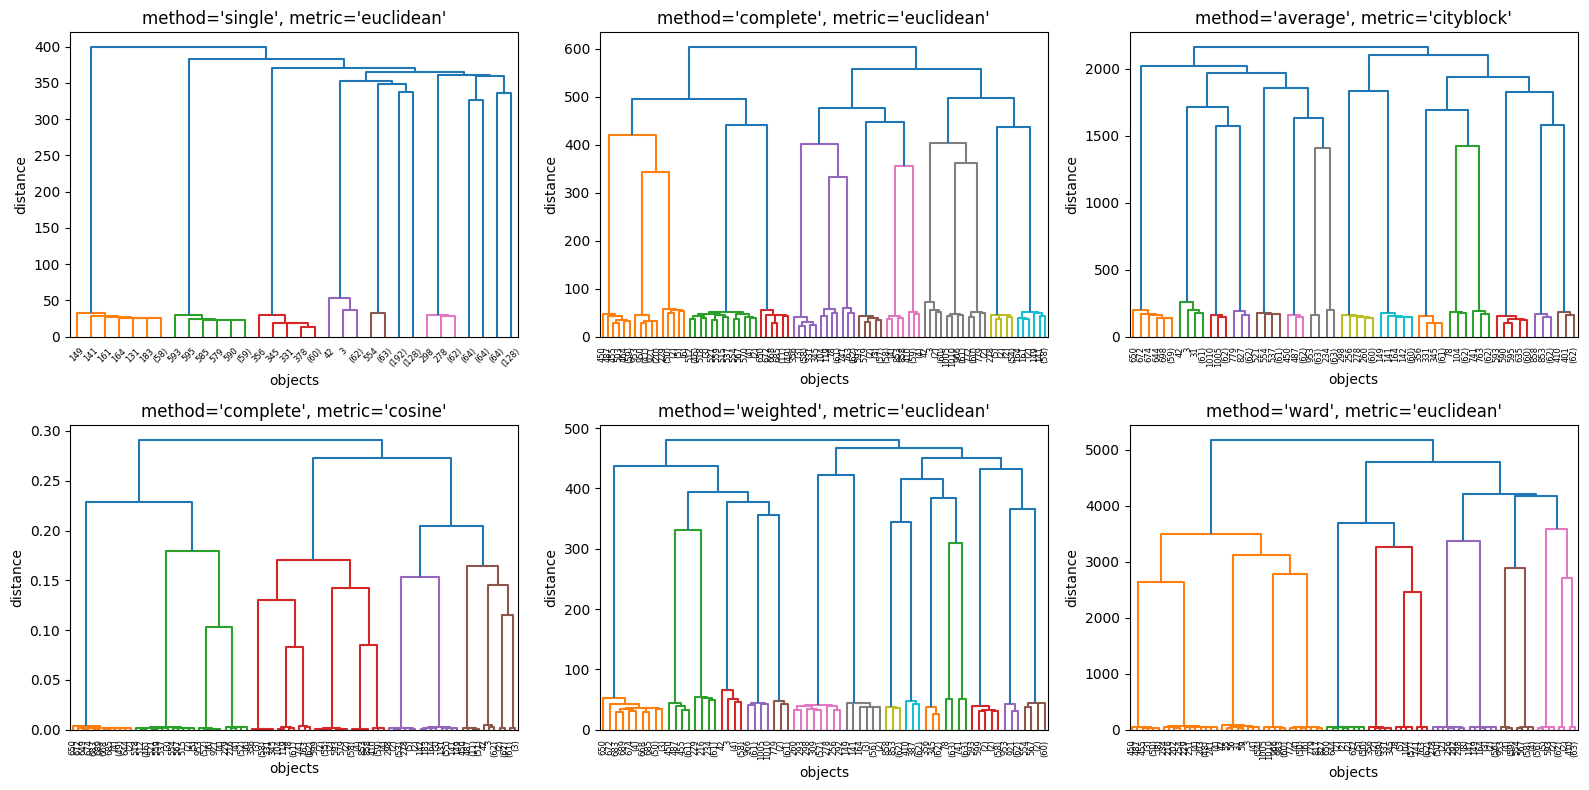

In [145]:
dendro_select = [
    ("single",   "euclidean"),
    ("complete", "euclidean"),
    ("average",  "cityblock"),
    ("complete", "cosine"),
    ("weighted", "euclidean"),
    ("ward",     "euclidean"),
]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for (method, metric), ax in zip(dendro_select, axes.ravel()):
    Z = linkage(X, method=method, metric=metric)
    dendrogram(
        Z,
        ax=ax,
        truncate_mode="level",  # чтобы графики были читаемыми на большом n
        p=6,
        leaf_font_size=6,
    )
    ax.set_title(f"method='{method}', metric='{metric}'")
    ax.set_ylabel("distance")
    ax.set_xlabel("objects")

plt.tight_layout()
plt.show()

**Вопрос:** На какой дендрограмме разделение на кластеры наиболее наглядно? Сделайте предположение почему?

метод complete выглядит наиболее читаемо визуально

### Использование Дендрограммы для кластеризации

Как вы убедились выше, дендрограмму можно использовать для предположения о количестве кластеров. Для реализации иерархической кластеризации можно использовать метод [Agglomerative Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html), который использует дендрограмму для объединения данных в кластеры

Примените метод Agglomerative Clustering с параметрами наилучшей дендрограммы, которую вы получили выше. Посчитайте метрику NMI

In [8]:
from sklearn.cluster import AgglomerativeClustering

In [147]:
# выбор из "лучшей" дендрограммы на глаз
method = "complete"
metric = "euclidean"

k = len(np.unique(y))        # сравниваемся с числом классов из dim032-l.txt

agg = AgglomerativeClustering(n_clusters=k, linkage=method, metric=metric)
labels = agg.fit_predict(X)

print(f"AgglomerativeClustering(linkage='{method}', metric='{metric}', k={k})")
print("NMI =", NMI(y, labels, average_method="arithmetic"))

AgglomerativeClustering(linkage='complete', metric='euclidean', k=21)
NMI = 0.8987488128229597


### Метрики

Вообще оценить качество кластеризации мы можем только если проверяем гипотезу о том, что данные разделимы на какие-то известные нам классы. То есть известны истинные метки классов

В этом случае нам интересны две вещи:
1. В одном кластере находятся точки только из одного класса ([Homogeneity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html))
2. Точки одного класса попадают целиком в один кластер ([Completeness](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html))

Данные метрики имеют имеют схожий подход с метриками классификации Precision и Recall соотвественно

Чтобы смотреть на ситуацию в целом, используется среднее гармоническое этих величин, она же [V-measure](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html), что соотвествует F-score, при этом, конечно, можно выбирать, какой из метрик отдается большее предпочтение (параметр *beta*). Дефолтная NMI соотвествует V-meausre с $beta=1$

Теперь посмотрите, как меняются предложенные метрики на методе Agglomerative Clustering при разном количестве кластеров (большем, меньшем и равном количеству классов)

In [14]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

 k  homogeneity  completeness  v_measure    NMI
16       0.8992        0.9073     0.9032 0.9032
17       0.8992        0.9057     0.9024 0.9024
18       0.8992        0.9041     0.9017 0.9017
19       0.8993        0.9013     0.9003 0.9003
20       0.8993        0.8997     0.8995 0.8995
21       0.8994        0.8981     0.8987 0.8987
22       0.9012        0.8983     0.8997 0.8997
23       0.9012        0.8893     0.8952 0.8952
24       0.9015        0.8873     0.8943 0.8943
25       0.9017        0.8797     0.8906 0.8906
26       0.9018        0.8782     0.8898 0.8898


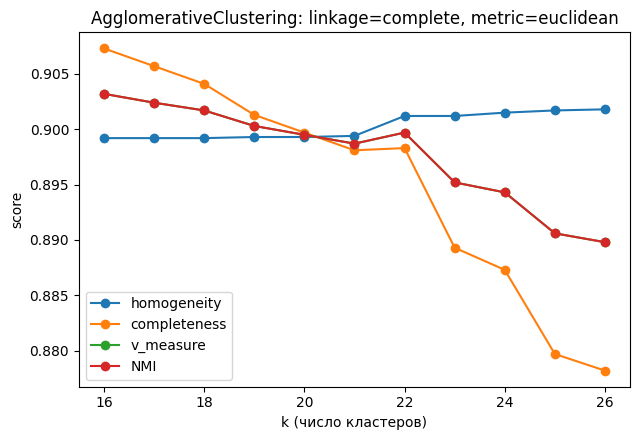

In [151]:
ks = list(range(max(2, k_true - 5), k_true + 6))

linkage_method = "complete" 
metric = "euclidean" 

rows = []
for k in ks:
    labels = AgglomerativeClustering(n_clusters=k, linkage=linkage_method, metric=metric).fit_predict(X)
    h = homogeneity_score(y, labels)
    c = completeness_score(y, labels)
    v = v_measure_score(y, labels) 
    nmi = NMI(y, labels, average_method="arithmetic")
    rows.append((k, h, c, v, nmi))

res = pd.DataFrame(rows, columns=["k", "homogeneity", "completeness", "v_measure", "NMI"]).round(4)
print(res.to_string(index=False))

# График метрик по k
plt.figure(figsize=(6.5, 4.5))
plt.plot(res["k"], res["homogeneity"], marker="o", label="homogeneity")
plt.plot(res["k"], res["completeness"], marker="o", label="completeness")
plt.plot(res["k"], res["v_measure"], marker="o", label="v_measure")
plt.plot(res["k"], res["NMI"], marker="o", label="NMI")
plt.xlabel("k (число кластеров)")
plt.ylabel("score")
plt.title(f"AgglomerativeClustering: linkage={linkage_method}, metric={metric}")
plt.legend()
plt.tight_layout()
plt.show()

**Вопрос:** Как меняются метрики в зависимости от количества кластеров? Обоснуйте, почему так происходит

При росте числа кластеров k кластеры становятся “чище” по составу классов, поэтому homogeneity растёт. Зато один и тот же истинный класс всё чаще рвётся на куски, completeness падает. V-measure — гармоническое среднее h и c, а NMI с арифметическим нормированием эквивалентна V-measure, так что обе падают, когда падение completeness перевешивает рост homogeneity.

Посмотрите, что будет с метриками, если перемешать предсказанные метки

 k  homogeneity  completeness  v_measure    NMI  homogeneity_shuffled  completeness_shuffled  v_measure_shuffled  NMI_shuffled
16       0.8992        0.9073     0.9032 0.9032                0.0448                 0.0452              0.0450        0.0450
17       0.8992        0.9057     0.9024 0.9024                0.0490                 0.0494              0.0492        0.0492
18       0.8992        0.9041     0.9017 0.9017                0.0417                 0.0419              0.0418        0.0418
19       0.8993        0.9013     0.9003 0.9003                0.0454                 0.0455              0.0454        0.0454
20       0.8993        0.8997     0.8995 0.8995                0.0495                 0.0495              0.0495        0.0495
21       0.8994        0.8981     0.8987 0.8987                0.0489                 0.0488              0.0489        0.0489
22       0.9012        0.8983     0.8997 0.8997                0.0536                 0.0535              0.053

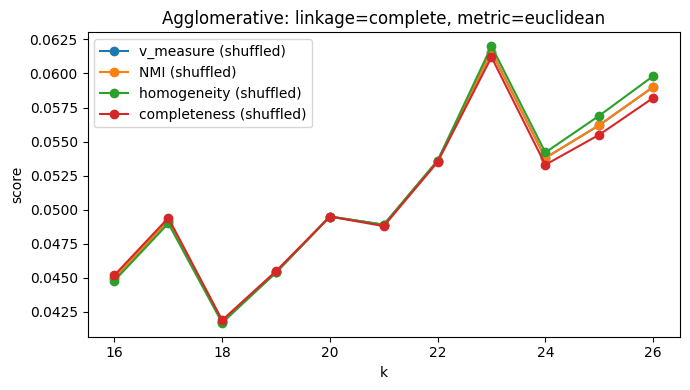

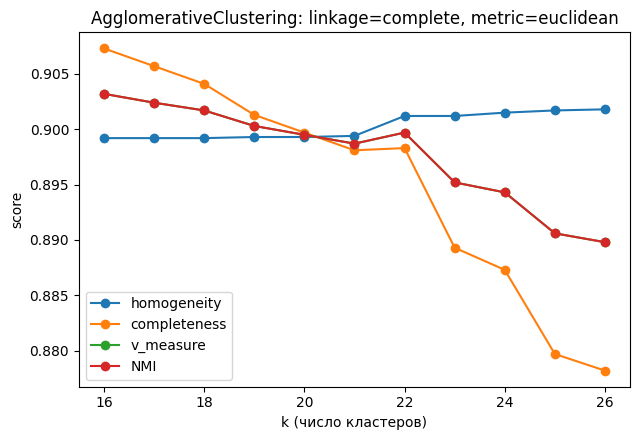

In [176]:
rows = []
for k in ks:
    labels = AgglomerativeClustering(n_clusters=k, linkage=linkage_method, metric=metric).fit_predict(X)

    h  = homogeneity_score(y, labels)
    c  = completeness_score(y, labels)
    v  = v_measure_score(y, labels)
    nm = NMI(y, labels, average_method="arithmetic")

    # перемешиваем присвоения меток между объектами (разрушаем структуру)
    perm_idx = np.random.permutation(len(labels))
    labels_sh = labels[perm_idx]
    h_s  = homogeneity_score(y, labels_sh)
    c_s  = completeness_score(y, labels_sh)
    v_s  = v_measure_score(y, labels_sh)
    nm_s = NMI(y, labels_sh, average_method="arithmetic")

    rows.append((k, h, c, v, nm, h_s, c_s, v_s, nm_s))

res = pd.DataFrame(
    rows,
    columns=["k","homogeneity","completeness","v_measure","NMI",
             "homogeneity_shuffled","completeness_shuffled","v_measure_shuffled","NMI_shuffled"]
).round(4)
print(res.to_string(index=False))

# График: сравнение V-measure/NMI до и после перемешивания
plt.figure(figsize=(7, 4))
# plt.plot(res["k"], res["v_measure"], marker="o", label="v_measure")
# plt.plot(res["k"], res["NMI"], marker="o", label="NMI")
plt.plot(res["k"], res["v_measure_shuffled"], marker="o", label="v_measure (shuffled)")
plt.plot(res["k"], res["NMI_shuffled"], marker="o", label="NMI (shuffled)")
plt.plot(res["k"], res["homogeneity_shuffled"], marker="o", label="homogeneity (shuffled)")
plt.plot(res["k"], res["completeness_shuffled"], marker="o", label="completeness (shuffled)")
plt.xlabel("k"); plt.ylabel("score")
plt.title(f"Agglomerative: linkage={linkage_method}, metric={metric}")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6.5, 4.5))
plt.plot(res["k"], res["homogeneity"], marker="o", label="homogeneity")
plt.plot(res["k"], res["completeness"], marker="o", label="completeness")
plt.plot(res["k"], res["v_measure"], marker="o", label="v_measure")
plt.plot(res["k"], res["NMI"], marker="o", label="NMI")
plt.xlabel("k (число кластеров)")
plt.ylabel("score")
plt.title(f"AgglomerativeClustering: linkage={linkage_method}, metric={metric}")
plt.legend()
plt.tight_layout()
plt.show()

**Вопрос:** Как изменились метрики? Обоснуйте результат

Теперь все метрики растут, однако это общий тренд, в остальном же метрики скорее ведут себя хаотично

Homogeneity = 1 − H(C|K)/H(C). При рандомном пересоединении K и C независимы, но H(C|K) мы считаем по маленьким кластерам. Энтропия по частотам в маленьких выборках имеет отрицательное смещение (оценка занижает истинную; порядок ≈ (|C|−1)/(2·n_k·ln2)). Чем больше мелких кластеров и синглтонов при большем k, тем ниже среднее H(C|K) и тем выше homogeneity.

Completeness = 1 − H(K|C)/H(K). Аналогично: для каждого класса считаем энтропию распределения по множеству кластеров; у оценок тоже отрицательное смещение. Плюс H(K) в знаменателе растёт вместе с k быстрее, чем H(K|C), поэтому доля падает, а completeness чуть растёт.

V-measure и NMI: при beta=1 это одна и та же величина, поэтому их кривые совпадают и двигаются вслед за балансом h/c.

## Задача 4

В файлах bank_genuine.txt и bank_forge.txt приводятся данные о фальшивых и настоящих деньгах. Объедините их в один массив, попробуйте разные алгоритмы кластеризации, найдите тот, что дает наилучший результат

In [12]:
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import pairwise_distances
from sklearn.cluster import cluster_optics_dbscan
import math


In [10]:
X_g = pd.read_csv("data/bank_genuine.txt", sep=r"\s+", header=None).to_numpy()
X_f = pd.read_csv("data/bank_forge.txt",   sep=r"\s+", header=None).to_numpy()
X = np.vstack([X_g, X_f])
y = np.r_[np.zeros(len(X_g), dtype=int), np.ones(len(X_f), dtype=int)]
k_true = 2

Используем все изученные за семинар методы кластерицации, а также все методы их оценки

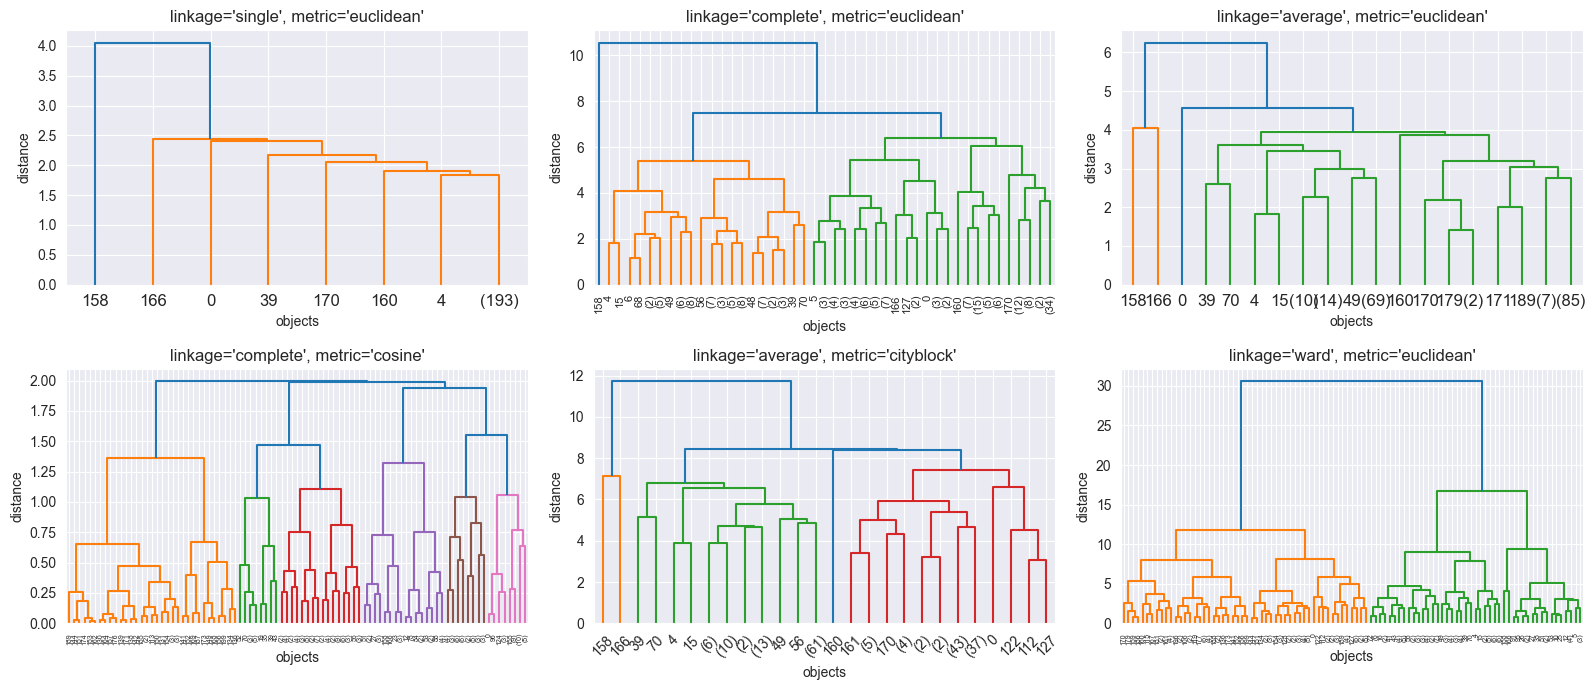

In [15]:


# Масштабирование
Xs = StandardScaler().fit_transform(X)
n = len(Xs)

dendro_select = [
    ("single",   "euclidean"),
    ("complete", "euclidean"),
    ("average",  "euclidean"),
    ("complete", "cosine"),
    ("average",  "cityblock"),
    ("ward",     "euclidean"),
]

def eval_labels(name, labels):
    k_pred = len(set(labels)) - (1 if -1 in labels else 0)
    noise  = int(np.sum(labels == -1))
    return dict(
        name=name, k_pred=k_pred, noise=noise,
        AMI=AMI(y, labels), ARI=ARI(y, labels),
        hom=homogeneity_score(y, labels),
        comp=completeness_score(y, labels),
        v=v_measure_score(y, labels),
        NMI=NMI(y, labels, average_method="arithmetic")
    )

rows = []

fig_rows, fig_cols = 2, math.ceil(len(dendro_select)/2)
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(16, 7))
axes = axes.ravel()

for i, (method, metric) in enumerate(dendro_select):
    Z = linkage(Xs, method=method, metric=metric)
    dendrogram(Z, ax=axes[i], truncate_mode="level", p=6)
    axes[i].set_title(f"linkage='{method}', metric='{metric}'")
    axes[i].set_ylabel("distance"); axes[i].set_xlabel("objects")
    labels_tree = fcluster(Z, t=k_true, criterion="maxclust")
    rows.append(eval_labels(f"Dendro[{method},{metric}]", labels_tree))

for j in range(len(dendro_select), len(axes)):
    axes[j].axis("off")
plt.tight_layout(); plt.show()

# AgglomerativeClustering
for method, metric in dendro_select:
    agg = AgglomerativeClustering(n_clusters=k_true, linkage=method, metric=metric)
    rows.append(eval_labels(f"Agglomerative[{method},{metric}]", agg.fit_predict(Xs)))

# K-means + Spectral
models = []
models += [("KMeans(k=2)", KMeans(n_clusters=2, n_init=20, random_state=0))]

D = pairwise_distances(Xs)
gamma = 1.0 / (np.median(D)**2 + 1e-12)
models += [("Spectral(RBF)", SpectralClustering(n_clusters=2, affinity="rbf",
                                                gamma=gamma, assign_labels="kmeans",
                                                random_state=0))]
for name, model in models:
    rows.append(eval_labels(name, model.fit_predict(Xs)))

# DBSCAN 
for ms in (4, 8, 12):
    nn = NearestNeighbors(n_neighbors=ms).fit(Xs)
    kth = np.sort(nn.kneighbors(Xs)[0][:, -1])
    base = float(np.percentile(kth, 95))
    for f in (0.8, 1.0, 1.2):
        eps = base * f
        rows.append(eval_labels(f"DBSCAN(eps={eps:.3f}, ms={ms})",
                                DBSCAN(eps=eps, min_samples=ms).fit_predict(Xs)))
        
# OPTICS

min_samples_list = [8, 10, 12]
xi_list = [0.06, 0.08, 0.10]
mcs = max(10, int(0.05 * len(Xs)))  # 5% выборки

for ms in min_samples_list:
    # 1) OPTICS с cluster_method="xi"
    for xi in xi_list:
        labels_xi = OPTICS(
            min_samples=ms,
            xi=xi,
            min_cluster_size=mcs,
            max_eps=np.inf,
            cluster_method="xi"
        ).fit_predict(Xs)
        rows.append(eval_labels(f"OPTICS-xi(xi={xi:.2f}, ms={ms}, mcs={mcs})", labels_xi))

    # 2) OPTICS порядок + DBSCAN-экстракция с eps по k-distance
    nn = NearestNeighbors(n_neighbors=ms).fit(Xs)
    kth = np.sort(nn.kneighbors(Xs)[0][:, -1])
    base_eps = float(np.percentile(kth, 95))

    optics_model = OPTICS(min_samples=ms, max_eps=np.inf).fit(Xs)
    for f in (0.8, 1.0, 1.2):
        eps = base_eps * f
        labels_db = cluster_optics_dbscan(
            reachability=optics_model.reachability_,
            core_distances=optics_model.core_distances_,
            ordering=optics_model.ordering_,
            eps=eps
        )
        rows.append(eval_labels(f"OPTICS-dbscan(eps={eps:.3f}, ms={ms})", labels_db))




In [16]:
res = pd.DataFrame(rows).sort_values(["AMI","ARI"], ascending=False).reset_index(drop=True)
res[["AMI","ARI","hom","comp","v","NMI"]] = res[["AMI","ARI","hom","comp","v","NMI"]].round(4)
print(res.to_string(index=False))

best_name = res.iloc[0]["name"]
print("\nЛучший по AMI:", best_name)

                             name  k_pred  noise     AMI     ARI    hom   comp      v    NMI
    Agglomerative[ward,euclidean]       2      0  0.8580  0.9212 0.8586 0.8586 0.8586 0.8586
           Dendro[ward,euclidean]       2      0  0.8580  0.9212 0.8586 0.8586 0.8586 0.8586
                      KMeans(k=2)       2      0  0.7954  0.8456 0.7943 0.7980 0.7961 0.7961
                    Spectral(RBF)       2      0  0.7602  0.8091 0.7583 0.7638 0.7610 0.7610
OPTICS-xi(xi=0.06, ms=12, mcs=10)       1    124  0.5709  0.5756 0.5605 0.5851 0.5725 0.5725
OPTICS-xi(xi=0.08, ms=12, mcs=10)       1    124  0.5709  0.5756 0.5605 0.5851 0.5725 0.5725
          Dendro[complete,cosine]       2      0  0.2583  0.1417 0.2225 0.3171 0.2615 0.2615
   Agglomerative[complete,cosine]       2      0  0.2583  0.1417 0.2225 0.3171 0.2615 0.2615
          DBSCAN(eps=1.469, ms=4)       1     14  0.0096  0.0023 0.0103 0.0281 0.0151 0.0151
        Dendro[average,euclidean]       2      0  0.0095  0.0002 0.010

**Вопрос:** Обоснуйте свой выбор и полученный результат

Это сложно назвать выбором, скорее это перебор. Ну и перебор показал, что Agglomerative основанный на дендрограмме – самый точный, что неудивительно, учитывая, что дендрограмма сама по себе достаточно информативна и анализ построенный на её основе также точен по AMI